# Photometric tables for RASCAS

This script allows to generate tables for photon initial conditions (PhotonsFromStars.f90). 

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from scipy.io import FortranFile
import numpy as np
import os
import sys
# RASCAS 
import lya_utils as lya

In [2]:
# Function taken fron ramses utils, by Trebitsch & Rosdahl.

def readRamsesSEDs(sedDir):
    """Read SED in ramses format and return

    Parameters:
    ----------------------------------------------------------------------
    sedDir: Directory containing the SED tables
    """
    # Read metallicity bins
    ZFile = open(sedDir+'/metallicity_bins.dat', 'r')
    nZ = eval(ZFile.readline())
    ZBins = []
    for Z in range(0,nZ): ZBins.append(eval(ZFile.readline()))
    ZFile.close()

    # Read age bins
    ageFile = open(sedDir+'/age_bins.dat', 'r')
    nAge = eval(ageFile.readline())
    ageBins = []
    for age in range(0,nAge): ageBins.append(eval(ageFile.readline()))
    ageFile.close()

    # Read wavelength bins and spectra
    sedFile = FortranFile(sedDir+'/all_seds.dat','r')
    nLambda = sedFile.read_ints()[0]
    lambdaBins = sedFile.read_reals()
    spectra = np.empty([nLambda,nAge,nZ])
    for iZ in range(0,nZ):
        for iAge in range(0,nAge):
            spectrum = sedFile.read_reals()
            spectra[:,iAge,iZ] = spectrum  

    return {'ZBins':ZBins, 'ageBins':ageBins, 'lambdaBins':lambdaBins,'spectra':spectra}

# spectra are in [Lsun / A / Msun]
# with Lsun = 3.826e33 erg/s and Msun = 2e33g
Lsun_cgs = 3.826e33
Msun_cgs = 2e33

In [3]:
ssp = readRamsesSEDs('/Users/blaizot/Documents/Astro/Dev/muse-svn/data/SED_LIBS/bc03/')

# Monochromatic luminosity densities (nb phot / s / A / Msun)
We generate tables giving the nb of photons emited per second and per Angstrom at a given wavelength. 
NB: This option should not be used to compute spectra, because they cannot be normalised properly ... It should be used assuming that all photons come out at the same frequency. 

> This can be used by PhotonsFromStars.f90 with options 
> ```fortran
> weight_type == 'Mono'
>spec_type == 'Mono'
> ```

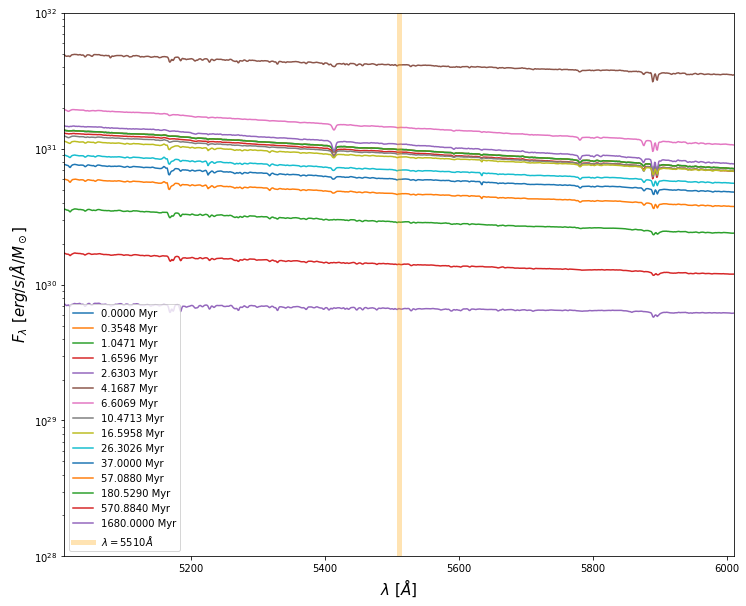

In [15]:
lambda0 = 5510.  # wavelength at which we want the flux [A]

i0 = np.where(abs(ssp['lambdaBins']-lambda0) == min(abs(ssp['lambdaBins']-lambda0)))[0][0]
lambda0 = ssp['lambdaBins'][i0]
f0 = ssp['spectra'][i0,:,:] * Lsun_cgs # erg/s/A/Msun
nu0 = lya.clight / (lambda0*1e-8) # [Hz]
n0 = f0 / lya.h_cgs / nu0  # nb of photons / s / A / Msun 
    
# save these to some ascii file 
f = open('PhotTable_Mono_%iA.txt'%(lambda0),'w')
f.write("# Number of photons emitted /s/Msun/A, at %f A. These are generated from BC03 models. \n"%(lambda0))
f.write("# First line is nages and nmets. Then come ages [Myr] (line 2), metallicities [absolute] (line 3), and wavelength [A] (line 4) \n")
f.write("# Then each line has N_%i [#/s/Msun/A] for all ages and one metallicity \n"%(lambda0))
nage = len(ssp['ageBins'])
nmet = len(ssp['ZBins'])
f.write("%i %i \n"%(nage,nmet))
for iage in range(nage): f.write("%.8e "%(ssp['ageBins'][iage]*1e-6))
f.write("\n")
for imet in range(nmet): f.write("%.8e "%(ssp['ZBins'][imet]))
f.write("\n")
f.write("%.8e \n"%(lambda0))
for imet in range(nmet):
    for iage in range(nage):f.write("%.8e "%(f0[iage,imet]))
    f.write("\n")
f.close()

# sanity-check plot 
plt.figure(figsize=(12,10))
for i in range(0,150,10):
    plt.plot(ssp['lambdaBins'],ssp['spectra'][:,i,1]*Lsun_cgs,label="%.4f Myr"%(ssp['ageBins'][i]*1e-6))

plt.xlim(lambda0-500.,lambda0+500)
plt.ylim(1e28,1e32)
plt.xlabel(r'$\lambda \ [\AA]$',fontsize=15)
plt.ylabel(r'$F_{\lambda} \ [erg / s / \AA / M_\odot]$',fontsize=15)
plt.yscale('log')
plt.axvline(lambda0,alpha=0.3,color='orange',linewidth=5,label=r'$\lambda = %i \AA$'%(lambda0))
plt.legend()


# Total Lya line luminosities (nb of phot. / s / Msun)

Here, we compute the number of Lyman continuum photons and use a typical value alpha_B = 0.68 to convert them into Lya photons. We save the number of photons emitted per second and per solar mass. 

The format here can be adapted to other emission lines.  

> This can be used by PhotonsFromStars.f90 with options 
> ```fortran
> weight_type == 'Mono'
>spec_type == 'Gauss'
> ```

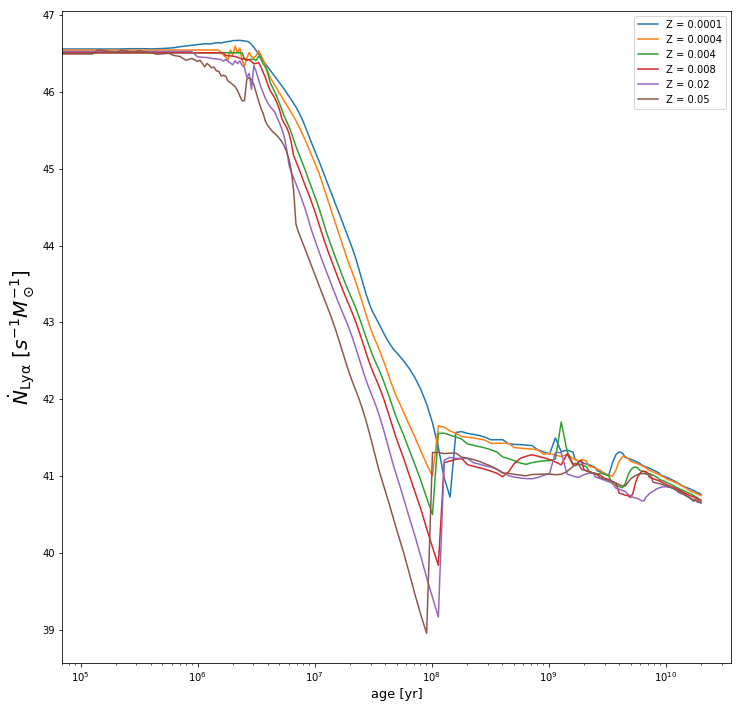

In [18]:
plt.figure(figsize=(12,12))

# save these to some ascii file 
f = open('PhotTable_Mono_Lya.txt','w')
f.write("# Number of Lya photons emitted /s/Msun. These are generated from BC03 models assuming alpha_B=0.68. \n")
f.write("# First line is nages and nmets. Then come ages [Myr] (line 2), metallicities [absolute] (line 3), and central wavelength [A] (line 4) \n")  
f.write("# Then each line has N_Lya [#/s/Msun] for all ages and one metallicity \n")
nage = len(ssp['ageBins'])
nmet = len(ssp['ZBins'])
f.write("%i %i \n"%(nage,nmet))
for iage in range(nage): f.write("%.8e "%(ssp['ageBins'][iage]*1e-6))
f.write("\n")
for imet in range(nmet): f.write("%.8e "%(ssp['ZBins'][imet]))
f.write("\n")
f.write("%.8e \n"%(lya.lambda0*1e8))  # line-center wavelength [A]
# comute number of Lyman continuum photons
lylim  = 912. # [Angstrom]
ilylim = np.where(abs(ssp['lambdaBins']-lylim) == min(abs(ssp['lambdaBins']-lylim)))[0][0]
lbds   = ssp['lambdaBins'][:ilylim+1]
for imet in range(nmet):
    x,y = [],[]
    for iage in range(nage):
        fly  = np.ravel(ssp['spectra'][0:ilylim+1,iage,imet]) * Lsun_cgs # [erg/s/A/Msun]
        fly  = fly * lbds
        nlyc = np.trapz(fly,lbds)
        nlyc = nlyc * 1.0e-8 / lya.h_cgs / (lya.clight) # [#/s/Msun]
        nlya = nlyc * 0.68  # nb of Lya photons
        x.append(ssp['ageBins'][iage])
        y.append(np.log10(nlya))
        f.write("%.8e "%(nlya))
    f.write("\n")
    plt.plot(x,y,label='Z = %s'%(ssp['ZBins'][imet]))

f.close()
plt.legend()
plt.xscale('log')
plt.ylabel(r'$\dot{N}_{\rm Ly\alpha} \ [s^{-1} M_\odot^{-1}]$',fontsize=20)
plt.xlabel('age [yr]',fontsize=13)

# Make power-law fits to SEDs (e.g. around Lya)
NB: Now sure how useful this is in the end given the strong stellar-atmosphere absorption at Lya for stars older than a few 100 Myr ... which are totally _not_ reproduced here ...  Still : 
> This can be used by PhotonsFromStars.f90 with options 
> ```fortran
> weight_type == 'PowLaw'
> spec_type == 'PowLaw'
> ```

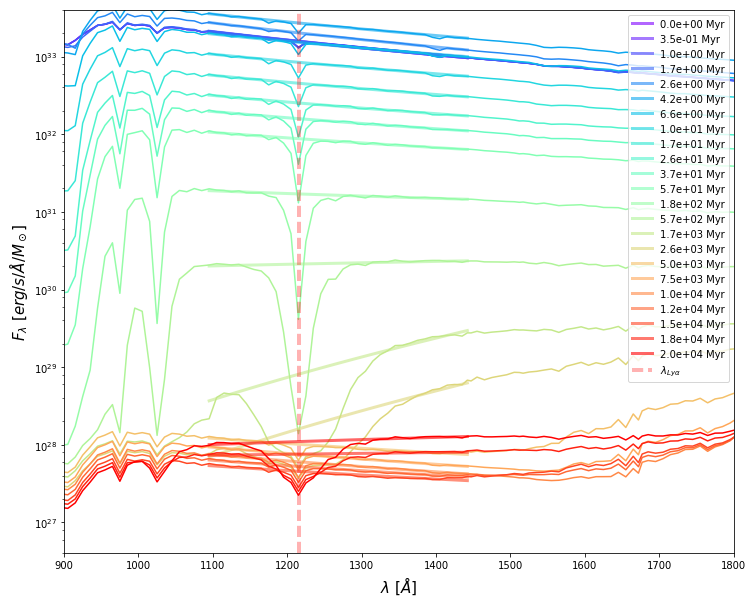

In [19]:
# define fit parameters
llow = 1100
ilow = np.where(abs(ssp['lambdaBins']-llow) == min(abs(ssp['lambdaBins']-llow)))[0][0]
lup  = 1450
iup  = np.where(abs(ssp['lambdaBins']-lup) == min(abs(ssp['lambdaBins']-lup)))[0][0]
flux = ssp['spectra'][ilow:iup,:,:] * Lsun_cgs # erg/s/Msun/A
loglambda = np.log10((ssp['lambdaBins'])[ilow:iup])
logf      = np.log10(flux)
lambda0   = 1216.


# save these to some ascii file 
f = open('PowerLawContLya.txt','w')
f.write("# Continuum power-law fits, from %f to %f A. These are in the form F_l = F_0 * (l/l0)^beta, with l0 = %f. \n"%(llow,lup,lambda0))
f.write("# First line is nages and nmets. Then come ages [Myr], then metallicities [absolute] (lines 2 and 3), and l0 [A] (line 4) \n")
f.write("# Then consecutive lines (corresponding to a single metallicity) have F_0 [erg/s/A/Msun] for all ages, beta for all ages. \n")
nage = len(ssp['ageBins'])
nmet = len(ssp['ZBins'])
f.write("%i %i \n"%(nage,nmet))
for iage in range(nage): f.write("%.8e "%(ssp['ageBins'][iage]*1e-6))
f.write("\n")
for imet in range(nmet): f.write("%.8e "%(ssp['ZBins'][imet]))
f.write("\n")
f.write("%.8e \n"%(lambda0))

# prepare plot 
plt.figure(figsize=(12,10))
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 221))

for imet in range(nmet):
    x,y = [],[]
    F_0s = ""
    betas = ""
    for iage in range(nage):
        p = np.polyfit(loglambda,logf[:,iage,imet],deg=1)#,w=f[:,i,1]**2)
        fit = 10.**( p[1] + p[0]*loglambda) 
        # remove the strong Lya absorption in the SEDs.
        ii = np.where(flux[:,iage,imet] > 0.8*fit)[0]
        p = np.polyfit(loglambda[ii],logf[ii,iage,imet],deg=1)
        fit = 10.**( p[1] + p[0]*loglambda) 
        # again, with stronger constraint
        ii = np.where(flux[:,iage,imet] > 0.95*fit)[0]
        p = np.polyfit(loglambda[ii],logf[ii,iage,imet],deg=1)
        fit = 10.**( p[1] + p[0]*loglambda) 
        # extract fit parameters
        beta   = p[0]
        logF_0 = p[1]+beta*np.log10(lambda0)
        F_0    = 10.**logF_0  # in erg/s/A/Msun
        F_0s = "%s %.8e"%(F_0s,F_0)
        betas = "%s %.8e"%(betas,beta)


        # check fit with plot
        if imet == 1 and iage%10==0:
            plt.plot(ssp['lambdaBins'],ssp['spectra'][:,iage,imet]*Lsun_cgs,color=colors[iage])
            fit = F_0 * (10.**loglambda/lambda0)**beta
            plt.plot(10.**loglambda,fit,color=colors[iage],linewidth=3,
                     alpha=0.6,label="%.1e Myr"%(ssp['ageBins'][iage]*1e-6))
            
    f.write("%s \n"%(F_0s))
    f.write("%s \n"%(betas))

f.close()
plt.xlim(900,1800)
plt.ylim(4e26,4e33)
plt.xlabel(r'$\lambda \ [\AA]$',fontsize=15)
plt.ylabel(r'$F_{\lambda} \ [erg / s / \AA / M_\odot]$',fontsize=15)
plt.yscale('log')
plt.axvline(1216,linestyle='--',alpha=0.3,color='red',linewidth=4,label=r'$\lambda_{Ly\alpha}$')
plt.legend(loc='upper right')


# Generate tabulated tables ... (small wavelength-range cutouts of BC03 SEDs, normalised).


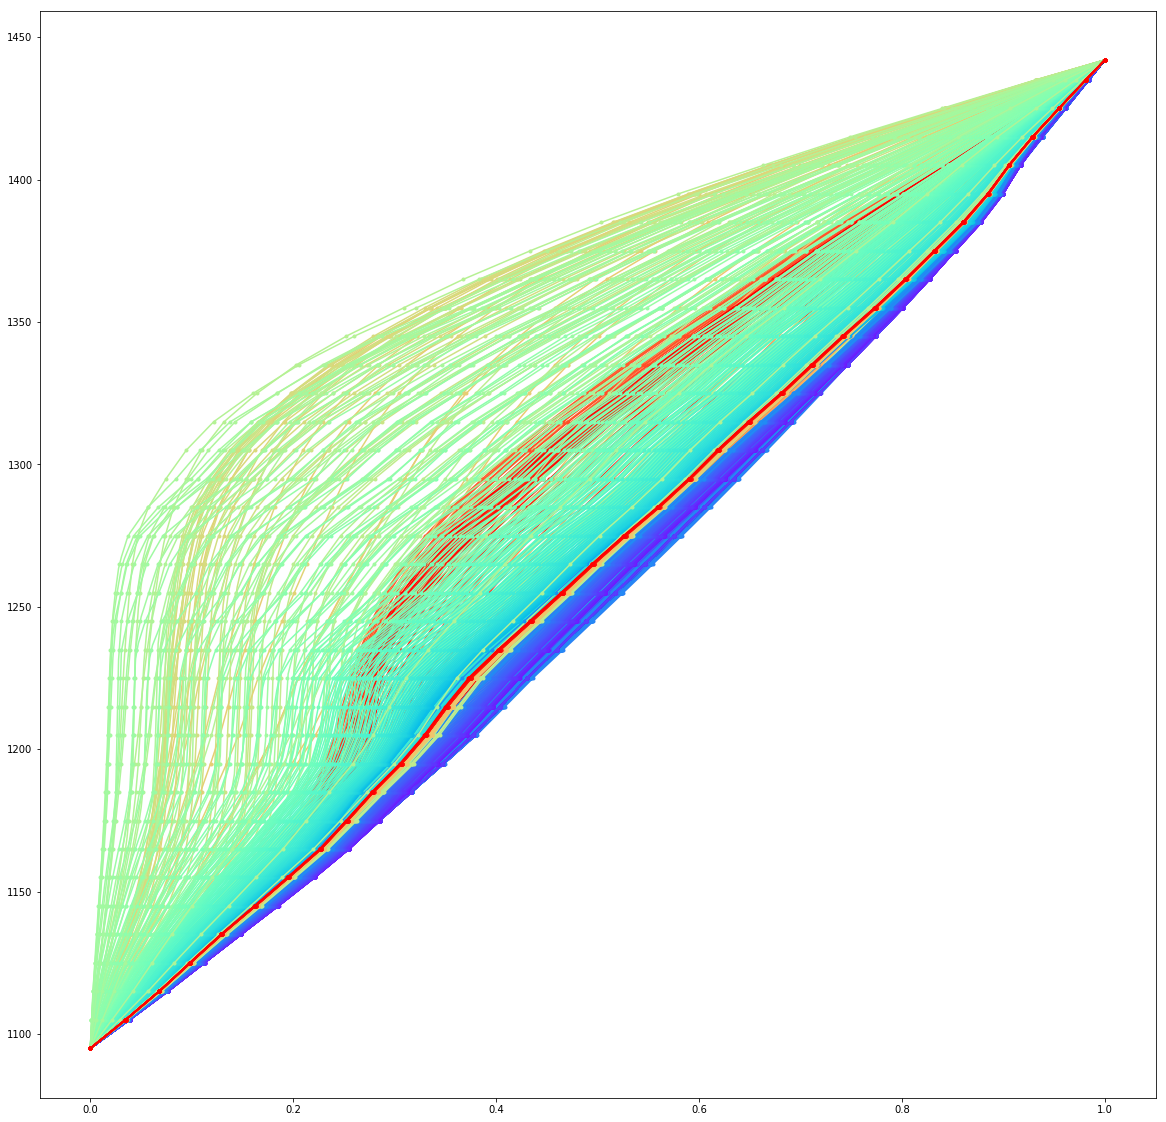

In [4]:
# set wavelength range 
llow = 1100  # min wavelength
lup  = 1450  # max wavelength
ilow = np.where(abs(ssp['lambdaBins']-llow) == min(abs(ssp['lambdaBins']-llow)))[0][0]
iup  = np.where(abs(ssp['lambdaBins']-lup) == min(abs(ssp['lambdaBins']-lup)))[0][0]
flux = ssp['spectra'][ilow:iup,:,:] * Lsun_cgs # [erg/s/Msun/A]
lbda = ssp['lambdaBins'][ilow:iup]  # [A]

# save these to some ascii file 
f = open('TabulatedContLya.txt','w')
f.write("# Tabulated SEDs, from %f to %f A, taken from BC03.  \n"%(llow,lup))
f.write("# First line is nages and nmets. Then come ages [Myr], then metallicities [absolute] (lines 2 and 3). \n")
f.write("# Line 4 is nbins. Following lines give nb of photons [#/s], lambda(x) with x regularly binned (nbins) in [0,1] (one line per age and metallicity). \n")
nage = len(ssp['ageBins'])
nmet = len(ssp['ZBins'])
f.write("%i %i \n"%(nage,nmet))
for iage in range(nage): f.write("%.8e "%(ssp['ageBins'][iage]*1e-6))
f.write("\n")
for imet in range(nmet): f.write("%.8e "%(ssp['ZBins'][imet]))
f.write("\n")

# binning for the reciprocal of P(<lambda)
ngood = 10*len(lbda)
f.write("%i \n"%(ngood))

# compute normalisation of each SED (nb of photons emitted in wavelength range)
plt.figure(figsize=(20,20))
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 221))
for imet in range(nmet):
    for iage in range(nage):
        fl    = np.ravel(flux[:,iage,imet])  # [erg/s/A/Msun]
        fl    = fl * lbda * 1.0e-8 / lya.h_cgs / (lya.clight) # [#/s/A/Msun]
        nphot = np.trapz(fl,lbda) # [#/s/Msun]
        f.write("%.8e "%(nphot))
        # cumulative proba distribution of photons... (P(<lambda))
        p = [0]
        l = [lbda[0]]
        pp = 0.
        for i in np.arange(1,len(lbda)):
            pp = pp + 0.5*(fl[i-1]+fl[i])*(lbda[i]-lbda[i-1])
            p.append(pp)
            l.append(lbda[i])
    
        if abs((pp-nphot)/nphot) > 1e-15: print 'oh no'

        x = np.ravel(l)
        y = np.ravel(p/max(p))       
        plt.plot(y,x,'.',color=colors[iage])
        # rebin regularly in y with high enough sampling to get accidental features ... 
        ygood = np.linspace(0,1,ngood)
        xgood = np.interp(ygood,y,x)
        plt.plot(ygood,xgood,color=colors[iage])

        for xg in xgood: f.write("%.8e "%(xg))
        f.write("\n")
    
f.close()




## write a fake phot table for tests

In [91]:
#same as above but all ages and metallicities correspond to : 
iage_test = 80
imet_test = 3

# set wavelength range 
llow = 1000  # min wavelength
lup  = 1500  # max wavelength
ilow = np.where(abs(ssp['lambdaBins']-llow) == min(abs(ssp['lambdaBins']-llow)))[0][0]
iup  = np.where(abs(ssp['lambdaBins']-lup) == min(abs(ssp['lambdaBins']-lup)))[0][0]
flux = ssp['spectra'][ilow:iup,:,:] * Lsun_cgs # [erg/s/Msun/A]
lbda = ssp['lambdaBins'][ilow:iup]  # [A]

# save these to some ascii file 
f = open('../tests/PhotonsFromStars/TestPhotTable_Table_iage%i_imet%i.txt'%(iage_test,imet_test),'w')
f.write("# Tabulated SEDs, from %f to %f A, taken from BC03.  \n"%(llow,lup))
f.write("# First line is nages and nmets. Then come ages [Myr], then metallicities [absolute] (lines 2 and 3). \n")
f.write("# Line 4 is nbins. Following lines give nb of photons [#/s], lambda(x) with x regularly binned (nbins) in [0,1] (one line per age and metallicity). \n")
nage = len(ssp['ageBins'])
nmet = len(ssp['ZBins'])
f.write("%i %i \n"%(nage,nmet))
for iage in range(nage): f.write("%.8e "%(ssp['ageBins'][iage]*1e-6))
f.write("\n")
for imet in range(nmet): f.write("%.8e "%(ssp['ZBins'][imet]))
f.write("\n")



# binning for the reciprocal of P(<lambda)
ngood = 10*len(lbda)
f.write("%i \n"%(ngood))

# compute normalisation of each SED (nb of photons emitted in wavelength range)
plt.figure(figsize=(20,20))
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 221))
for imet in range(nmet):
    for iage in range(nage):
        fl    = np.ravel(flux[:,iage_test,imet_test])  # [erg/s/A/Msun]
        fl    = fl * lbda * 1.0e-8 / lya.h_cgs / (lya.clight) # [#/s/A/Msun]

        # rebin specs before integration.
        lll = np.linspace(lbda[0],lbda[-1],5*len(lbda))
        fff = np.interp(lll,lbda,fl)

        # cumulative proba distribution of photons... (P(<lambda))
        p = [0]
        l = [lbda[0]]
        pp = 0.
        for i in np.arange(1,len(lll)):
            pp = pp + 0.5*(fff[i-1]+fff[i])*(lll[i]-lll[i-1])
            p.append(pp)
            l.append(lll[i])
    
        f.write("%.8e "%(pp)) # [#/s/Msun]
        
        x = np.ravel(l)
        y = np.ravel(p/max(p))   # P(<lambda)
        # rebin regularly in y with high enough sampling to get accidental features ... 
        ygood = np.linspace(0,1,ngood)
        xgood = np.interp(ygood,y,x)
        for xg in xgood: f.write("%.8e "%(xg))
        f.write("\n")

f.close()



